In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import lightgbm as lgb
import xgboost as xgb

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from scipy.stats import skew

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [5]:
from tqdm import tqdm as tqdm
import gc

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
class BaseModel:
    def __init__(self):
        self.unstack_data = {}  # 特征工程计算历史增长的临时数据1，详见genHistoryIncrease部分
        self.unstack_data2 = {} # 特征工程计算历史增长的临时数据2
        
        self.train = None # 训练集
        self.test = None # 测试集
        self.valid = None # 验证集
        self.train_target = None # 训练目标
        self.valid_target = None # 验证目标
        self.features = None # 训练时使用的特征列表
        self.cat_feats = None # 类别特征列表
        self.weight = None # LGB训练时的样本权重
        self.model = None # 训练好的模型
        # LGB默认训练参数
        self.default_param = {
            'num_leaves':2**5-1,
            'reg_alpha':0.25,
            'reg_lambda':0.25,
            'objective':'mse',
            'max_depth':-1,
            'learning_rate':0.05, 
            'min_child_samples':5, 
            'random_state':2019,
            'n_estimators':2000, 
            'subsample':0.9,
            'colsample_bytree':0.7 
        }
    # 读取数据
    def readData(self,path='./data/'):
        """
        读取数据
        @param: path:存储文件夹
        """
        train_sales = pd.read_csv(path+'train_sales_data.csv')
        train_search = pd.read_csv(path+'train_search_data.csv')
        train_user_reply = pd.read_csv(path+'train_user_reply_data.csv')
        test = pd.read_csv(path+'evaluation_public.csv')

        train = pd.merge(train_sales, train_search, on=['province','adcode','model','regYear','regMonth'],how='left')
        train = pd.merge(train, train_user_reply, on=['model','regYear','regMonth'],how='left')


        ##########################预测测试集popularity######################
        msk16 = train_search['regYear']==2016
        msk17 = train_search['regYear']==2017
        f = 'popularity'

        # 观察数据分布发现，[2016年12月、2017年1～3月]和[2017年9,10,11,12月]分布趋势相似，
        # 将其看作短期周期，以此根据2017年4~7月数据预测2018年1~4月数据

        p = train_search.groupby(['province','model','regMonth','regYear'],as_index=False).first()

        a = p['popularity'][((p['regMonth'].isin([1,2,3]))&(p['regYear']==2017))|((p['regMonth'].isin([12]))&(p['regYear']==2016))].mean()
        b =p['popularity'][p['regMonth'].isin([9,10,11,12])][p['regYear']==2017].mean()
        c = b/a
        d = p['popularity'][p['regMonth'].isin([4,5,6,7])][p['regYear']==2017].values

        search = p[p['regYear']==2017][p['regMonth'].isin([1,2,3,4])].reset_index(drop=True).drop('regYear',axis=1)
        search['popularity'] = d * c
        search['popularity'] = search['popularity'].apply(round)
    
        test = pd.merge(test, search, on=['province','adcode','model','regMonth'],how='left')
        train.drop('carCommentVolum',axis=1,inplace=True)
        train.drop('newsReplyVolum',axis=1,inplace=True)
        ##################################################################
        
        model_bodyType = train[['model','bodyType']].groupby(['model'],as_index=False).first()
        test = pd.merge(test, model_bodyType, on='model', how='left') 
        return train, test
    # 特征工程
    def transStrFeats(self, df, l):
        """
        字符特征转码
        @param: df:数据
        @param: l:要转码的特征列表
        """
        for f in l:
            map_dict = {i:j+1 for j,i in enumerate(df[f].unique())}
            df[f] = df[f].map(map_dict)
        return df
    def genHistoryFeature(self, dataset_, groupby_cols, col, time_win):
        """
        将历史数据作为特征
        @param: groupby_cols: groupby使用的特征
        @param: col: 将该列的历史数据作为特征
        @param: time_win: 使用的历史数据月份跨度列表（例:[1,2]，将前1个月和前2个月的数据作为特征）
        例：genHistoryFeature(df, ['model'], 'salesVolume', [1,2]) 将每个model前1，2个月的salesVolume作为当前月的特征
        """
        dataset = dataset_.copy()
        df = dataset[groupby_cols+[col]].copy()
        for i in time_win:
            history = df.copy()
            history['mt'] += i
            history.rename(columns={col:col+'_{}m_ago'.format(i)},inplace=True)
            dataset = pd.merge(dataset, history, on=groupby_cols, how='left')
        return dataset
    def genHistoryStatistic(self, train, col, fea, month, method):
        """
        计算历史数据统计特征
        author: Arima
        @param: train:数据集
        @param: col:groupby使用的特征
        @param: fea:计算历史统计特征的目标特征
        @oaram: month:使用的历史数据月份跨度列表（例:[1,2]，将前1个月和前2个月的历史统计数据作为特征）
        @param: method:统计方法，如'mean'
        例：genHistoryStatistic(df, ['province','bodyType','mt'],'salesVolume',[1,2,3],'mean')
            以df中每个province每种bodyType每个单月为单位，计算salesVolume在前第1，2，3中每个月的均值
        """
        traincopy=train[col].copy()
        traincopy[fea]=train[fea]
        featurename='_'.join(col)+'_'+ fea +'_'+method
        traincopy=traincopy.groupby(col)[fea].agg([method]).reset_index()
        traincopy.rename(columns={method:featurename},inplace=True)

        for diff in month:
            feature_name = 'pre' + featurename + '_' + str(diff)
            trainset2=traincopy.copy()
            trainset2['mt'] = diff + trainset2['mt']
            trainset2.rename(columns={featurename:feature_name},inplace=True)
            train = train.merge(trainset2, on=col, how='left')
            del trainset2
        return train
    def genSalesStatistic(self, dataset_, groupby_cols, col, start, width, methods):
        """
        生成某条特征的滑窗统计特征
        @param: groupby_cols:groupby的特征列表
        @param: col:滑窗的目标列
        @param: start:起点, 当月的前n个月，若start=4,当月为12,则窗口起点为8
        @param: width:窗口宽度
        @param: methods:处理方法列表，np.mean等
        例：genSalesStatistic(df, ['province','bodyType','model','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
            以每个province中每种bodyType中每个model的每个mt为单位，计算salesVolume在前第1到第3个月共3个月中的均值和总和
        """
        dataset = dataset_.copy()
        df = dataset[groupby_cols+[col]].copy().groupby(groupby_cols,as_index=False).mean()
        data = df.copy()
        feats = []
        for i in range(start,start+width):
            tmp = df.copy()
            tmp['mt'] += i
            tmp.rename(columns={col:'Label_{}m_ago'.format(i)},inplace=True)
            feats.append('Label_{}m_ago'.format(i))
            data = pd.merge(data,tmp,on=groupby_cols, how='left')
        data.drop(col,axis=1,inplace=True)
        bar = tqdm(methods, desc='{}_{}_{}to{}'.format('&'.join(groupby_cols), col, start, start+width-1))
        for method in bar:
            if method=='weighted_mean':
                name = '{}_{}_{}_{}to{}'.format('&'.join(groupby_cols), col, method, start, start+width-1)
                def genTheta(length):
                    theta = np.array(list(range(1,length+1)))
                    theta = np.log1p(theta)
                    theta /= sum(theta)
                    return theta
                theta = genTheta(len(feats))
                data[name] = 0.
                for i,f in enumerate(feats):
                    data[name] += data[f] * theta[i]
            else:
                name = '{}_{}_{}_{}to{}'.format('&'.join(groupby_cols), col, method.__name__, start, start+width-1)
                data[name] = method(data[feats],axis=1)
        data.drop(feats,axis=1,inplace=True)
        dataset = pd.merge(dataset, data, on=groupby_cols, how='left')
        return dataset
    def getHistoryIncrease(self, dataset_, month, step=1, wind=1, col='salesVolume'):
        """
        以每个province中的每个model为单位，生成数据的历史增长趋势特征
        @param: df:数据集
        @param: month:当前模型预测的月份（用于界定计算增长趋势特征的边界）
        @param: step:月份跨度
        @param: wind:滑窗大小
        @param: col:生成该特征相关的历史增长趋势特征
        例：getHistoryIncrease(df, 2, wind=3, step=2, col='salesVolume')
            当前预测月份为2月，以当前月份的前第2个月份相较于前第5(2+3)个月份的增长幅度作为当月特征，
            即以4月较1月的增长幅度作为6月的特征
        """
        dataset = dataset_.copy()
        if col not in self.unstack_data.keys():
            res = []
            bar = tqdm(dataset['province'].unique(), desc='history increase')
            for i in bar:
                for j in dataset['model'].unique():
                    msk = (dataset['province']==i) & (dataset['model']==j)
                    df = dataset[msk].copy().reset_index(drop=True)
                    df = df[['mt',col]].set_index('mt').T
                    df['province'] = i
                    df['model'] = j
                    res.append(df)
            res = pd.concat(res).reset_index(drop=True)
            self.unstack_data[col] = res.copy()
            # unstack_data：每一行数据代表一个province中的一个model，共24列，
            #               分别代表该province中该model在该月的销量

        res = self.unstack_data[col].copy()
        res_ = res.copy()
        for i in range(step+1+wind,25+month):
            res_[i] = (res[i-step] - res[i-(step+wind)]) / res[i-(step+wind)]
        for i in range(1,step+wind+1):
            res_[i]=np.NaN
        res = res_.set_index(['province','model']).stack().reset_index()
        res.rename(columns={0:'{}_last{}_{}_increase'.format(col,step,wind),'level_2':'mt'},inplace=True)
        dataset = pd.merge(dataset, res, on=['province','model','mt'], how='left')

        return dataset
    def getHistoryIncrease2(self, dataset_, month, step=1,wind=1, col='salesVolume'):
        """
        以每个model为单位，生成数据的历史增长趋势特征
        @param: df:数据集
        @param: month:当前模型预测的月份（用于界定计算增长趋势特征的边界）
        @param: step:月份跨度
        @param: wind:滑窗大小
        @param: col:生成该特征相关的历史增长趋势特征
        例：getHistoryIncrease(df, 2, wind=3, step=2, col='salesVolume')
            当前预测月份为2月，以当前月份的前第2个月份相较于前第5(2+3)个月份的增长幅度作为当月特征，
            即以4月较1月的增长幅度作为6月的特征
        """
        dataset = dataset_.copy()
        if col not in self.unstack_data2.keys():
            res = []
            tmp = dataset.groupby(['model','mt'],as_index=False).sum()
            bar = tqdm(tmp['model'].unique(), desc='history increase')
            for i in bar:
                msk = tmp['model']==i
                df = tmp[msk].copy().reset_index(drop=True)
                df = df[['mt',col]].set_index('mt').T
                df['model'] = i
                res.append(df)
            res = pd.concat(res).reset_index(drop=True)
            self.unstack_data2[col] = res.copy()
            # unstack_data2：每一行数据代表一个model，共24列，分别代表该model在该月的销量

        res = self.unstack_data2[col].copy()
        res_ = res.copy()
        for i in range(step+1+wind,25+month):
            res_[i] = (res[i-step] - res[i-(step+wind)]) / res[i-(step+wind)]
        for i in range(1,step+wind+1):
            res_[i]=np.NaN
        res = res_.set_index(['model']).stack().reset_index()
        res.rename(columns={0:'{}_last{}_{}_increase2'.format(col,step,wind),'level_2':'mt'},inplace=True)
        dataset = pd.merge(dataset, res, on=['model','mt'], how='left')
        return dataset
    def getIncreaseCount(self, dataset_, month, wind=6, step=1, col='salesVolume'):
        """
        统计历史增长次数
        @param: dataset_:数据集
        @param: month:当前模型预测的月份
        @param: wind:滑窗大小
        @param: step:跨度
        @param: col:统计增长次数的目标特征
        例：getIncreaseCount(df, 2, wind=6, step=1, col='salesVolume')
            当前预测月份为2月，计算前第1个月至前第7个月之间汽车销量增长的次数
        """
        dataset = dataset_.copy()
        if col not in self.unstack_data.keys():
            res = []
            bar = tqdm(dataset['province'].unique(), desc='history increase count')
            for i in bar:
                for j in dataset['model'].unique():
                    msk = (dataset['province']==i) & (dataset['model']==j)
                    df = dataset[msk].copy().reset_index(drop=True)
                    df = df[['mt',col]].set_index('mt').T
                    df['province'] = i
                    df['model'] = j
                    res.append(df)
            res = pd.concat(res).reset_index(drop=True)
            self.unstack_data[col] = res.copy()

        res = self.unstack_data[col].copy()
        res2 = res.copy()
        res3 = res.copy()
        for i in range(step+wind,25+month):
            res2[i] = (res[i-step] - res[i-step-1])<0
        for i in range(step+wind,25+month):
            res3[i] = np.sum(res2[list(range(step+wind,i))],axis=1)
        for i in range(1,wind+step):
            res3[i]=np.NaN
        res = res3.set_index(['province','model']).stack().reset_index()
        res.rename(columns={0:'{}_last{}_increase_count_step{}'.format(col,wind,step),'level_2':'mt'},inplace=True)
        dataset = pd.merge(dataset, res, on=['province','model','mt'], how='left')

        return dataset
    def getDecreaseCount(self, dataset_, month, wind=6, step=1, col='salesVolume'):
        """
        统计历史减少次数 （未使用）
        @param: dataset_:数据集
        @param: month:当前模型预测的月份
        @param: wind:滑窗大小
        @param: step:跨度
        @param: col:统计减少次数的目标特征
        例：getDecreaseCount(df, 2, wind=6, step=1, col='salesVolume')
            当前预测月份为2月，计算前第1个月至前第7个月之间汽车销量减少的次数
        """
        dataset = dataset_.copy()
        if col not in self.unstack_data.keys():
            res = []
            bar = tqdm(dataset['province'].unique(), desc='history increase count')
            for i in bar:
                for j in dataset['model'].unique():
                    msk = (dataset['province']==i) & (dataset['model']==j)
                    df = dataset[msk].copy().reset_index(drop=True)
                    df = df[['mt',col]].set_index('mt').T
                    df['province'] = i
                    df['model'] = j
                    res.append(df)
            res = pd.concat(res).reset_index(drop=True)
            self.unstack_data[col] = res.copy()

        res = self.unstack_data[col].copy()
        res2 = res.copy()
        res3 = res.copy()
        for i in range(step+wind,25+month):
            res2[i] = (res[i-step] - res[i-step-1])>0
        for i in range(step+wind,25+month):
            res3[i] = np.sum(res2[list(range(step+wind,i))],axis=1)
        for i in range(1,wind+step):
            res3[i]=np.NaN
        res = res3.set_index(['province','model']).stack().reset_index()
        res.rename(columns={0:'{}_last{}_decrease_count_step{}'.format(col,wind,step),'level_2':'mt'},inplace=True)
        dataset = pd.merge(dataset, res, on=['province','model','mt'], how='left')

        return dataset
    def getChangeCount(self, dataset_, month, wind=6, step=1, col='salesVolume'):
        """
        统计历史销量趋势改变的次数，即从上升趋势转为下降或从下降趋势转为上升 （未使用）
        @param: dataset_:数据集
        @param: month:当前模型预测的月份
        @param: wind:滑窗大小
        @param: step:跨度
        @param: col:统计趋势改变的次数的目标特征
        例：getChangeCount(df, 2, wind=6, step=1, col='salesVolume')
            当前预测月份为2月，计算前第1个月至前第7个月之间汽车销量趋势改变的次数
        """
        dataset = dataset_.copy()
        if col not in self.unstack_data.keys():
            res = []
            bar = tqdm(dataset['province'].unique(), desc='history increase count')
            for i in bar:
                for j in dataset['model'].unique():
                    msk = (dataset['province']==i) & (dataset['model']==j)
                    df = dataset[msk].copy().reset_index(drop=True)
                    df = df[['mt',col]].set_index('mt').T
                    df['province'] = i
                    df['model'] = j
                    res.append(df)
            res = pd.concat(res).reset_index(drop=True)
            self.unstack_data[col] = res.copy()

        res = self.unstack_data[col].copy()
        res2 = res.copy()
        res3 = res.copy()

        res[0] = res[1]
        res[25+month] = res[24+month]
        for i in range(step+wind,25+month):
            res2[i] = ((res[i]-res[i-1]) * (res[i+1]-res[i])) < 0
        for i in range(step+wind,25+month):
            res3[i] = np.sum(res2[list(range(step+wind,i))],axis=1)
        for i in range(1,wind+step):
            res3[i]=np.NaN
        res = res3.set_index(['province','model']).stack().reset_index()
        res.rename(columns={0:'{}_last{}_change_count_step{}'.format(col,wind,step),'level_2':'mt'},inplace=True)
        dataset = pd.merge(dataset, res, on=['province','model','mt'], how='left')

        return dataset
    def getChangePattern(self, dataset_, month, wind=4, step=1, col='salesVolume'):
        """
        获取历史销量趋势（类别特征） （未使用）
        @param: dataset_:数据集
        @param: month:当前模型预测的月份
        @param: wind:滑窗大小
        @param: step:跨度
        @param: col:统计趋势的目标特征
        例：getChangePattern(df, 2, wind=6, step=1, col='salesVolume')
            当前预测月份为2月，计算前第1个月至前第7个月之间汽车销量的趋势，如：上升、下降、下降、上升
        """
        dataset = dataset_.copy()
        if col not in self.unstack_data.keys():
            res = []
            bar = tqdm(dataset['province'].unique(), desc='history increase count')
            for i in bar:
                for j in dataset['model'].unique():
                    msk = (dataset['province']==i) & (dataset['model']==j)
                    df = dataset[msk].copy().reset_index(drop=True)
                    df = df[['mt',col]].set_index('mt').T
                    df['province'] = i
                    df['model'] = j
                    res.append(df)
            res = pd.concat(res).reset_index(drop=True)
            self.unstack_data[col] = res.copy()

        res = self.unstack_data[col].copy()
        res2 = res.copy()
        res3 = res.copy()
        for i in range(step+wind,25+month):
            res2[i] = ((res[i-step] - res[i-step-1])<0).astype(int).astype(str)
        for i in range(step+wind,25+month):
            res3[i] = res2[list(range(i-wind,i))].apply(lambda x:''.join([str(_) for _ in x]),axis=1)
        for i in range(1,wind+step):
            res3[i]=np.NaN
        res = res3.set_index(['province','model']).stack().reset_index()
        res.rename(columns={0:'{}_last{}_change_pattern_step{}'.format(col,wind,step),'level_2':'mt'},inplace=True)
        dataset = pd.merge(dataset, res, on=['province','model','mt'], how='left')

        return dataset

    # 生成数据集
    def trainTestSplit(self, df, month, split_type=1):
        """
        划分训练测试验证集
        @param: df:总数据集
        @param: month:当前预测的月份
        @param: split_type:训练测试集划分方式：1或2
                1为鱼佬开源框架中的验证集滑动选取，2为固定9-12月数据为验证集
        """
        if split_type==1:
            all_mask = df['mt'].between(13,24+month-1)
            train_mask = df['mt'].between(13,19+month)
            valid_mask = df['mt']==(20+month)
            test_mask = df['mt']==(24+month)
        elif split_type==2:
            train_mask = df['mt'].between(1,21)
            valid_mask = df['mt'].between(22,24)
            test_mask = df['mt']==(24+month)
            all_mask = train_mask | valid_mask
        
        return all_mask, train_mask, valid_mask, test_mask
    def genDataset(self, month, pred=None, train_test_split_type=1):
        """
        生成做好特征工程的数据集
        @param: pred: 已经预测完成的测试集销量预测字典
        @param: month: 当前预测的月份
        @param: train_test_split_type:训练测试集划分方式：1或2
        """
        train, test = self.readData()
        trainset = pd.concat([train, test]).reset_index(drop=True)
        train_len = train.shape[0]

        #############################特征工程#############################
        trainset = self.transStrFeats(trainset, ['province','model'])
        trainset['mt'] = (trainset['regYear'] - 2016) * 12 + trainset['regMonth']

        #*************
        test = trainset.iloc[train_len:].copy()
        if len(pred)!=0:
            for m in pred.keys():
                trainset['salesVolume'][trainset['mt']==m] = pred[m]
        #*************
        ## 将target除以当月天数以消除每个月天数不一对特征的影响
        day_map = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
        trainset['dayCount']=trainset['regMonth'].map(day_map)
        trainset.loc[(trainset.regMonth==2)&(trainset.regYear==2016),'dayCount']=29
        trainset['salesVolume']/=trainset['dayCount']
        trainset['popularity']/=trainset['dayCount']

        # 特征交叉
        trainset['province&model'] = trainset['province'].astype('str')+" "+trainset['model'].astype('str')
        trainset['district&model'] = trainset['adcode'].astype('str').apply(lambda x:x[0])+" "+trainset['model'].astype('str')
        
        # 当月去年标签
        trainset = self.genHistoryFeature(trainset, ['province','bodyType','model','mt'], 'salesVolume', [1,2,3,4,5,6,12])
        trainset = self.genHistoryFeature(trainset, ['province','bodyType','model','mt'], 'popularity', [1,2,3,4,5,6,12])

        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'median')

        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'median')
    
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'median')

        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'median')
        
        # 历史月份统计特征
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 2, 3, [np.mean, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 3, 3, [np.mean, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 4, 3, [np.mean, np.min, np.max, np.median, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 5, 3, [np.mean, np.min, np.max, np.median, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 6, 3, [np.mean, np.min, np.max, np.median, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 1, 6, [np.mean, np.min, np.max, np.median, skew, np.sum, np.std])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 1, 12, [np.mean, np.min, np.max, np.median, skew, np.sum, np.std])
        
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','mt'], 'salesVolume', 2, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','mt'], 'salesVolume', 3, 3, [np.mean, np.sum, skew])
        
        trainset = self.genSalesStatistic(trainset, ['model','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['model','mt'], 'salesVolume', 2, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['model','mt'], 'salesVolume', 3, 3, [np.mean, np.sum, skew])
        
        # 历史月份销量涨幅
        trainset = self.getHistoryIncrease(trainset,month,wind=1,step=month,col='salesVolume')
        trainset = self.getHistoryIncrease(trainset,month,wind=2,step=month,col='salesVolume')
        trainset = self.getHistoryIncrease(trainset,month,wind=3,step=month,col='salesVolume')
        trainset = self.getHistoryIncrease(trainset,month,wind=1,step=12,col='salesVolume')

        trainset = self.getHistoryIncrease(trainset,month,wind=1,step=month,col='popularity')
        trainset = self.getHistoryIncrease(trainset,month,wind=2,step=month,col='popularity')
        trainset = self.getHistoryIncrease(trainset,month,wind=3,step=month,col='popularity')
        trainset = self.getHistoryIncrease(trainset,month,wind=1,step=12,col='popularity')
        
        trainset = self.getIncreaseCount(trainset,month,wind=6,step=1,col='salesVolume')
        
        # 还原
        trainset['salesVolume'] *= trainset['dayCount']
        # 去掉无效特征
        drop_l = ['adcode','forecastVolum','id','popularity']
        trainset.drop(drop_l,axis=1,inplace=True)
        
        # 生成特征列表
        if month==1:
            features = [_ for _ in trainset.columns if _ not in ['salesVolume','carCommentVolum','newsReplyVolum']]
        else:
            features = [_ for _ in trainset.columns if _ not in ['salesVolume','popularity','carCommentVolum','newsReplyVolum']]
            
        cat_feats = ['model', 'province', 'bodyType', 'province&model', 'district&model', 'regMonth']#salesVolume_last_change_pattern
        for f in cat_feats:
            trainset[f] = trainset[f].astype('category')
        
        # 划分训练、验证集
        all_mask, train_mask, valid_mask, test_mask = self.trainTestSplit(trainset, month, split_type=train_test_split_type)
        
        all_data = trainset[all_mask].copy()
        valid = trainset[valid_mask].copy()
        test = trainset[test_mask].copy()
        train = trainset[train_mask].copy()
        
        label = 'salesVolume'
        train_target = train[label].copy()
        valid_target = valid[label].copy()

        # 根据每个model销量均值设置训练权重，均值越低权重越高
        weight_df = train[['salesVolume','model']].groupby('model',as_index=False).mean().sort_values(by='salesVolume',ascending=False).reset_index(drop=True)
        weight_df['weight'] = 0.0
        weight_df['weight'].loc[:20]=1
        weight_df['weight'].loc[20:40]=1.5
        weight_df['weight'].loc[40:]=2.0
        weight_df.drop('salesVolume',axis=1,inplace=True)
        train = pd.merge(train, weight_df, on='model', how='left')
        weight = train.pop('weight')
        
        self.all = all_data
        self.train = train
        self.test = test
        self.valid = valid
        self.train_target = train_target
        self.valid_target = valid_target
        self.features = features
        self.cat_feats = cat_feats
        self.weight = weight
        self.origin_valid = self.valid.copy()
            
    # 模型训练
    def getScore(self, df, oof):
        """
        计算线下得分
        @param: 训练集
        @param: oof:验证集预测结果
        """
        score = 0
        for f in df['model'].unique():
            msk = df['model']==f
            tmp = df[msk]
            score += np.sqrt(mean_squared_error(tmp['salesVolume'],oof[msk]))/(tmp['salesVolume']).mean()
        score = 1-score/df['model'].nunique()
        return score
    def model_train(self, model='lgb', param=None, use_weight=True, log=True, verbose=100, num_round=20000):
        """
        模型训练高级封装
        @param: model:模型类别：lgb/xgb
        @param: param:模型参数
        @param: use_weight:lgb训练时使用训练权重
        @param: log:对预测目标进行对数处理
        @param: verbose:模型训练过程中可视化周期
        @param: num_round:不早停的情况下模型训练轮数
        """
        data = {}
        data['train'] = self.train.copy()
        data['test'] = self.test.copy()
        data['valid'] = self.valid.copy()
        data['train_target'] = self.train_target.copy()
        data['valid_target'] = self.valid_target.copy()
        data['all_data'] = self.all.copy()
        data['features'] = self.features.copy()
        data['cat_feats'] = self.cat_feats.copy()
        data['weight'] = self.weight.copy()
        
        if model=='lgb':
            oof, pred, feat_importance = self.lgb_train(data, param, use_weight, log, verbose, num_round)
            oof_df = self.valid.copy()
            
        else:
            oof, pred = self.xgb_train(data, param, log, verbose, num_round)
            feat_importance = None
            oof_df = self.origin_valid.copy()
        
        print("Final Score:",self.getScore(oof_df, oof))
            
        return oof, pred, feat_importance

    def lgb_train(self, data, param=None, use_weight=True, log=True, verbose=100, num_round=20000):
        train = data['train']
        test = data['test']
        valid = data['valid']
        train_target = data['train_target']
        valid_target = data['valid_target']
        all_data = data['all_data']
        features = data['features']
        cat_feats = data['cat_feats']
        all_target = all_data['salesVolume']
        
        if not use_weight:
            weight = None
        else:
            weight = data['weight']

        if log:
            train_target = np.log1p(train_target)
            valid_target = np.log1p(valid_target)
            all_target = np.log1p(all_target)

        if param is None:
            param = self.default_param.copy()
        model = lgb.LGBMRegressor(**param)
        model.fit(train[features], train_target.values, 
              eval_set=[(train[features], train_target.values),(valid[features], valid_target.values)], 
              categorical_feature=cat_feats, 
              early_stopping_rounds=100, verbose=verbose,
              sample_weight=weight)
        
        feature_importance_df = pd.DataFrame()
        feature_importance_df["Feature"] = features
        feature_importance_df["importance"] = model.feature_importances_
        
        oof = model.predict(valid[features], num_iteration=model.best_iteration_)

        print("Refitting...", end='\t')
        model.n_estimators = model.best_iteration_ + 100
        model.fit(all_data[features], all_target, categorical_feature=cat_feats)
        pred = model.predict(test[features], num_iteration=model.best_iteration_)
        print("Done")

        gc.collect()
        if log:
            oof = np.expm1(oof)
            pred = np.expm1(pred)
        self.model = model
        print("CV score: {:<8.5f}".format(self.getScore(valid, oof)))
        print("")
        return oof, pred, feature_importance_df
    def xgb_train(self, data, param=None, log=True, verbose=100, num_round=20000):
        train = data['train']
        test = data['test']
        valid = data['valid']
        train_target = data['train_target']
        valid_target = data['valid_target']
        all_data = data['all_data']
        features = data['features']
        cat_feats = data['cat_feats']
        all_target = all_data['salesVolume']
        
        lbl = LabelEncoder()
        train_len = train.shape[0]
        valid_len = valid.shape[0]
        test_len = test.shape[0]
        df = pd.concat([train,valid,test,all_data])
        df = df[features+['salesVolume']]
        for i in tqdm(cat_feats):
            df[i] = lbl.fit_transform(df[i].astype(str))
        train = df.iloc[:train_len]
        valid = df.iloc[train_len:train_len+valid_len]
        test = df.iloc[train_len+valid_len:train_len+valid_len+test_len]
        all_data = df.iloc[train_len+valid_len+test_len:]
        
        features = list(train.columns)
        features.remove('salesVolume')

        if log:
            train_target = np.log1p(train_target)
            valid_target = np.log1p(valid_target)
            all_target = np.log1p(all_target)

        model = xgb.XGBRegressor(
                                max_depth=5 , learning_rate=0.05, n_estimators=2000, 
                                objective='reg:gamma', tree_method = 'hist',subsample=0.9, 
                                colsample_bytree=0.7, min_child_samples=5,eval_metric = 'rmse' 
                                )
        model.fit(train[features], train_target.values, 
              eval_set=[(train[features], train_target.values),(valid[features], valid_target.values)], 
              early_stopping_rounds=100, verbose=100)
        
        oof = model.predict(valid[features])

        print("Refitting...", end='\t')
        model.n_estimators = model.best_iteration + 100
        model.fit(all_data[features], all_target)
        pred = model.predict(test[features])
        print("Done")

        gc.collect()
        if log:
            oof = np.expm1(oof)
            pred = np.expm1(pred)
        self.model = model
        print("CV score: {:<8.5f}".format(self.getScore(valid, oof)))
        print("")
        return oof, pred

In [12]:
class BaseModel2(BaseModel):
    def __init__(self):
        self.unstack_data = {}  # 特征工程计算历史增长的临时数据1，详见genHistoryIncrease部分
        self.unstack_data2 = {} # 特征工程计算历史增长的临时数据2
        
        self.train = None # 训练集
        self.test = None # 测试集
        self.valid = None # 验证集
        self.train_target = None # 训练目标
        self.valid_target = None # 验证目标
        self.features = None # 训练时使用的特征列表
        self.cat_feats = None # 类别特征列表
        self.weight = None # LGB训练时的样本权重
        self.model = None # 训练好的模型
        # LGB默认训练参数
        self.default_param = {
            'num_leaves':2**5-1,
            'reg_alpha':0.25,
            'reg_lambda':0.25,
            'objective':'mse',
            'max_depth':-1,
            'learning_rate':0.05, 
            'min_child_samples':5, 
            'random_state':2019,
            'n_estimators':2000, 
            'subsample':0.9,
            'colsample_bytree':0.7 
        }
    def genDataset(self, month, pred=None, train_test_split_type=2):
        """
        生成做好特征工程的数据集
        @param: pred: 已经预测完成的测试集销量预测字典
        @param: month: 当前预测的月份
        """
        train, test = self.readData()
        trainset = pd.concat([train, test]).reset_index(drop=True)
        train_len = train.shape[0]

        #############################特征工程#############################
        trainset = self.transStrFeats(trainset, ['province','model'])
        trainset['mt'] = (trainset['regYear'] - 2016) * 12 + trainset['regMonth']

        #*************
        test = trainset.iloc[train_len:].copy()
        if len(pred)!=0:
            for m in pred.keys():
                trainset['salesVolume'][trainset['mt']==m] = pred[m]
        #*************
        ## 将target除以当月天数以消除每个月天数不一对特征的影响
        day_map = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
        trainset['dayCount']=trainset['regMonth'].map(day_map)
        trainset.loc[(trainset.regMonth==2)&(trainset.regYear==2016),'dayCount']=29
        trainset['salesVolume']/=trainset['dayCount']
        trainset['popularity']/=trainset['dayCount']

        
        # 特征交叉
        trainset['province&model'] = trainset['province'].astype('str')+" "+trainset['model'].astype('str')
        trainset['district&model'] = trainset['adcode'].astype('str').apply(lambda x:x[0])+" "+trainset['model'].astype('str')
        
        # 当月去年标签
        trainset = self.genHistoryFeature(trainset, ['province','bodyType','model','mt'], 'salesVolume', [1,2,3,4,5,6,12])#[1,2,3,4,12]
        trainset = self.genHistoryFeature(trainset, ['province','bodyType','model','mt'], 'popularity', [1,2,3,4,5,6,12])

        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'salesVolume',[1,2,3],'median')

    
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'salesVolume',[1,2,3],'median')
    
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['province','bodyType','mt'],'popularity',[1,2,3],'median')

        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'mean')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'min')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'max')
        trainset=self.genHistoryStatistic(trainset.copy(),['model','mt'],'popularity',[1,2,3],'median')
        
        # 历史月份统计特征
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 2, 3, [np.mean, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 3, 3, [np.mean, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 4, 3, [np.mean, np.min, np.max, np.median, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 5, 3, [np.mean, np.min, np.max, np.median, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 6, 3, [np.mean, np.min, np.max, np.median, skew, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 1, 6, [np.mean, np.min, np.max, np.median, skew, np.sum, np.std])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','model','mt'], 'salesVolume', 1, 12, [np.mean, np.min, np.max, np.median, skew, np.sum, np.std])
        
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','mt'], 'salesVolume', 2, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['province','bodyType','mt'], 'salesVolume', 3, 3, [np.mean, np.sum, skew])
        
        trainset = self.genSalesStatistic(trainset, ['model','mt'], 'salesVolume', 1, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['model','mt'], 'salesVolume', 2, 3, [np.mean, np.sum])
        trainset = self.genSalesStatistic(trainset, ['model','mt'], 'salesVolume', 3, 3, [np.mean, np.sum, skew])
        
        # 历史月份销量涨幅
        trainset = self.getHistoryIncrease(trainset,month,wind=1,step=month,col='salesVolume')
        trainset = self.getHistoryIncrease(trainset,month,wind=2 ,step=month,col='salesVolume')
        trainset = self.getHistoryIncrease(trainset,month,wind=3 ,step=month,col='salesVolume')
        trainset = self.getHistoryIncrease(trainset,month,wind=1 ,step=12,col='salesVolume')

        trainset = self.getHistoryIncrease(trainset,month,wind=1,step=month,col='popularity')
        trainset = self.getHistoryIncrease(trainset,month,wind=2 ,step=month,col='popularity')
        trainset = self.getHistoryIncrease(trainset,month,wind=3 ,step=month,col='popularity')
        trainset = self.getHistoryIncrease(trainset,month,wind=1 ,step=12,col='popularity')
        
        trainset = self.getIncreaseCount(trainset,month,wind=6,step=1,col='salesVolume')
        #trainset = self.getDecreaseCount(trainset,month,wind=6,step=1,col='salesVolume')
        
        #trainset = self.getChangeCount(trainset,month,wind=12,step=1,col='salesVolume')
        #trainset = self.getChangeCount(trainset,month,wind=6,step=1,col='salesVolume')
        
        #trainset = self.getChangePattern(trainset,month,wind=3,step=1,col='salesVolume')
        
        # 还原
        trainset['salesVolume'] *= trainset['dayCount']
        # 去掉无效特征
        drop_l = ['adcode','forecastVolum','id','popularity']
        trainset.drop(drop_l,axis=1,inplace=True)
        
        # 生成特征列表
        if month==1:
            features = [_ for _ in trainset.columns if _ not in ['salesVolume','carCommentVolum','newsReplyVolum']]
        else:
            features = [_ for _ in trainset.columns if _ not in ['salesVolume','popularity','carCommentVolum','newsReplyVolum']]
            
        cat_feats = ['model', 'province', 'bodyType', 'province&model', 'district&model', 'regMonth']#salesVolume_last_change_pattern
        for f in cat_feats:
            trainset[f] = trainset[f].astype('category')
        
        ## 划分训练、验证集
        all_mask, train_mask, valid_mask, test_mask = self.trainTestSplit(trainset, month, split_type=train_test_split_type)
        
        all_data = trainset[all_mask].copy()
        valid = trainset[valid_mask].copy()
        test = trainset[test_mask].copy()
        train = trainset[train_mask].copy()
        
        label = 'salesVolume'
        train_target = train[label].copy()
        valid_target = valid[label].copy()

        # 根据每个model销量均值设置训练权重，均值越低权重越高
        weight_df = train[['salesVolume','model']].groupby('model',as_index=False).mean().sort_values(by='salesVolume',ascending=False).reset_index(drop=True)
        weight_df['weight'] = 0.0
        weight_df['weight'].loc[:20]=1
        weight_df['weight'].loc[20:40]=1.5
        weight_df['weight'].loc[40:]=2.0
        weight_df.drop('salesVolume',axis=1,inplace=True)
        train = pd.merge(train, weight_df, on='model', how='left')
        weight = train.pop('weight')
        
        self.all = all_data
        self.train = train
        self.test = test
        self.valid = valid
        self.train_target = train_target
        self.valid_target = valid_target
        self.features = features
        self.cat_feats = cat_feats
        self.weight = weight
        self.origin_valid = self.valid.copy()

### 训练模型

---

In [13]:
params = {
    'bagging_freq': 1,
    "bagging_seed": 23,
    'bagging_fraction': 0.85,#0.85
    'boost': 'gbdt',
    #'feature_fraction': 0.9,
    #'feature_fraction_seed':11,
    'learning_rate': 0.01,
    'max_depth': 6,#6
    "lambda_l1": 0.15,
    "lambda_l2": 1.5,
    'min_data_in_leaf': 20,
    "metric": 'mae',#mae
    'num_leaves': 28,
    'num_threads': -1,
    'objective': 'regression',
    }

In [14]:
pred_dict = {}
oof_dict = {}
for i in [1,2,3,4]:
    print("-"*100)
    print("Predicting Month:"+str(i))
    print("-"*100)
    model = BaseModel2()
    model.genDataset(month=i, pred=pred_dict)
    oof, pred, feat_importance = model.model_train()
    oof_dict[20+i] = oof
    pred_dict[24+i] = pred

----------------------------------------------------------------------------------------------------
Predicting Month:1
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.76it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0526617	valid_1's l2: 0.0743339
[200]	valid_0's l2: 0.0348735	valid_1's l2: 0.072773
Early stopping, best iteration is:
[196]	valid_0's l2: 0.0353133	valid_1's l2: 0.0726741
Refitting...	Done
CV score: 0.71172 

Final Score: 0.7117225711375157
----------------------------------------------------------------------------------------------------
Predicting Month:2
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0528767	valid_1's l2: 0.0750727
[200]	valid_0's l2: 0.0349858	valid_1's l2: 0.073504
[300]	valid_0's l2: 0.0274713	valid_1's l2: 0.0736144
Early stopping, best iteration is:
[274]	valid_0's l2: 0.0290501	valid_1's l2: 0.0733767
Refitting...	Done
CV score: 0.71123 

Final Score: 0.7112325747595503
----------------------------------------------------------------------------------------------------
Predicting Month:3
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0531476	valid_1's l2: 0.0746645
[200]	valid_0's l2: 0.0352451	valid_1's l2: 0.0734826
Early stopping, best iteration is:
[164]	valid_0's l2: 0.0396686	valid_1's l2: 0.0731966
Refitting...	Done
CV score: 0.70645 

Final Score: 0.7064525035865279
----------------------------------------------------------------------------------------------------
Predicting Month:4
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0530469	valid_1's l2: 0.0742391
[200]	valid_0's l2: 0.0348163	valid_1's l2: 0.0726472
Early stopping, best iteration is:
[153]	valid_0's l2: 0.0405969	valid_1's l2: 0.0722882
Refitting...	Done
CV score: 0.70880 

Final Score: 0.7087985969540921


In [15]:
# 将每个月的验证及预测结果合并，计算总体线下得分
df = model.valid.copy()
df['pred'] = 0
for m in oof_dict.keys():
    df['pred'][df.mt==m] = oof_dict[m]
valid = df[df.mt.between(21,24)]
model.getScore(valid,valid['pred'])

0.7082569947338964

In [16]:
pred_dict2 = {}
oof_dict2 = {}
for i in [1,2,3,4]:
    print("-"*100)
    print("Predicting Month:"+str(i))
    print("-"*100)
    model = BaseModel()
    model.genDataset(month=i, pred=pred_dict, train_test_split_type=2)
    oof, pred, feat_importance = model.model_train(model='xgb')
    oof_dict2[20+i] = oof
    pred_dict2[24+i] = pred

----------------------------------------------------------------------------------------------------
Predicting Month:1
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 10.39it/s]


[0]	validation_0-rmse:5.28098	validation_1-rmse:5.41347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.50545	validation_1-rmse:0.549038
[200]	validation_0-rmse:0.286614	validation_1-rmse:0.286609
[300]	validation_0-rmse:0.261353	validation_1-rmse:0.286377
Stopping. Best iteration:
[211]	validation_0-rmse:0.283341	validation_1-rmse:0.28568

Refitting...	Done
CV score: 0.67626 

Final Score: 0.6762621697688007
----------------------------------------------------------------------------------------------------
Predicting Month:2
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 11.61it/s]


[0]	validation_0-rmse:5.28098	validation_1-rmse:5.41347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.505644	validation_1-rmse:0.551804
[200]	validation_0-rmse:0.284368	validation_1-rmse:0.286365
[300]	validation_0-rmse:0.260075	validation_1-rmse:0.284792
Stopping. Best iteration:
[269]	validation_0-rmse:0.266818	validation_1-rmse:0.284182

Refitting...	Done
CV score: 0.68638 

Final Score: 0.68637685016141
----------------------------------------------------------------------------------------------------
Predicting Month:3
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 11.01it/s]


[0]	validation_0-rmse:5.28098	validation_1-rmse:5.41347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.505498	validation_1-rmse:0.547354
[200]	validation_0-rmse:0.286447	validation_1-rmse:0.282572
[300]	validation_0-rmse:0.263344	validation_1-rmse:0.282913
Stopping. Best iteration:
[239]	validation_0-rmse:0.276283	validation_1-rmse:0.282071

Refitting...	

100%|██████████| 6/6 [00:00<00:00, 10.33it/s]


[0]	validation_0-rmse:5.28098	validation_1-rmse:5.41347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.505672	validation_1-rmse:0.549825
[200]	validation_0-rmse:0.285345	validation_1-rmse:0.284144
[300]	validation_0-rmse:0.261753	validation_1-rmse:0.282701
Stopping. Best iteration:
[253]	validation_0-rmse:0.272085	validation_1-rmse:0.28178

Refitting...	Done
CV score: 0.68620 

Final Score: 0.6862044605229038


In [17]:
df = model.valid.copy()
df['pred'] = 0
for m in oof_dict2.keys():
    df['pred'][df.mt==m] = oof_dict2[m]
valid = df[df.mt.between(21,24)]
model.getScore(valid,valid['pred'])

0.6852985224231293

---

In [18]:
pred_dict3 = {}
oof_dict3 = {}
for i in [1,2,3,4]:
    print("-"*100)
    print("Predicting Month:"+str(i))
    print("-"*100)
    model = BaseModel()
    model.genDataset(month=i, pred=pred_dict3)
    oof, pred, feat_importance = model.model_train()
    oof_dict3[20+i] = oof
    pred_dict3[24+i] = pred

----------------------------------------------------------------------------------------------------
Predicting Month:1
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0342005	valid_1's l2: 0.0515036
[200]	valid_0's l2: 0.0208467	valid_1's l2: 0.0514885
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0266352	valid_1's l2: 0.0510688
Refitting...	Done
CV score: 0.75176 

Final Score: 0.7517626605949397
----------------------------------------------------------------------------------------------------
Predicting Month:2
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0354657	valid_1's l2: 0.0804584
[200]	valid_0's l2: 0.0221704	valid_1's l2: 0.0790057
[300]	valid_0's l2: 0.0166864	valid_1's l2: 0.0776734
[400]	valid_0's l2: 0.0131533	valid_1's l2: 0.0768555
[500]	valid_0's l2: 0.0107292	valid_1's l2: 0.0766301
[600]	valid_0's l2: 0.00890999	valid_1's l2: 0.0765818
Early stopping, best iteration is:
[533]	valid_0's l2: 0.0100856	valid_1's l2: 0.0764849
Refitting...	Done
CV score: 0.73420 

Final Score: 0.734198895005842
----------------------------------------------------------------------------------------------------
Predicting Month:3
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0360684	valid_1's l2: 0.0547327
[200]	valid_0's l2: 0.0227036	valid_1's l2: 0.0538667
[300]	valid_0's l2: 0.0172525	valid_1's l2: 0.0539728
Early stopping, best iteration is:
[205]	valid_0's l2: 0.0223435	valid_1's l2: 0.0536985
Refitting...	Done
CV score: 0.77727 

Final Score: 0.7772675419616506
----------------------------------------------------------------------------------------------------
Predicting Month:4
----------------------------------------------------------------------------------------------------


history increase: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.0363574	valid_1's l2: 0.130985
[200]	valid_0's l2: 0.0233539	valid_1's l2: 0.122935
[300]	valid_0's l2: 0.0179351	valid_1's l2: 0.121614
[400]	valid_0's l2: 0.0144939	valid_1's l2: 0.121504
[500]	valid_0's l2: 0.0119515	valid_1's l2: 0.121217
[600]	valid_0's l2: 0.0102426	valid_1's l2: 0.121125
Early stopping, best iteration is:
[543]	valid_0's l2: 0.011167	valid_1's l2: 0.120891
Refitting...	Done
CV score: 0.62439 

Final Score: 0.6243912181252069


In [19]:
df = model.valid.copy()
df['pred'] = 0
for m in oof_dict3.keys():
    df['pred'][df.mt==m] = oof_dict3[m]
valid = df[df.mt.between(21,24)]
model.getScore(valid,valid['pred'])

0.6243912181252069

In [20]:
pred_dict4 = {}
oof_dict4 = {}
for i in [1,2,3,4]:
    print("-"*100)
    print("Predicting Month:"+str(i))
    print("-"*100)
    model = BaseModel()
    model.genDataset(month=i, pred=pred_dict4)
    oof, pred, feat_importance = model.model_train(model='xgb')
    oof_dict4[20+i] = oof
    pred_dict4[24+i] = pred

----------------------------------------------------------------------------------------------------
Predicting Month:1
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 29.60it/s]


[0]	validation_0-rmse:5.14456	validation_1-rmse:5.33678
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.440968	validation_1-rmse:0.518795
[200]	validation_0-rmse:0.193348	validation_1-rmse:0.249658
[300]	validation_0-rmse:0.166488	validation_1-rmse:0.251375
Stopping. Best iteration:
[261]	validation_0-rmse:0.175709	validation_1-rmse:0.249379

Refitting...	Done
CV score: 0.76411 

Final Score: 0.7641108559299745
----------------------------------------------------------------------------------------------------
Predicting Month:2
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 27.57it/s]


[0]	validation_0-rmse:5.16626	validation_1-rmse:5.27027
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.440776	validation_1-rmse:0.585885
[200]	validation_0-rmse:0.19659	validation_1-rmse:0.318744
[300]	validation_0-rmse:0.170535	validation_1-rmse:0.315359
[400]	validation_0-rmse:0.155197	validation_1-rmse:0.31357
Stopping. Best iteration:
[392]	validation_0-rmse:0.15646	validation_1-rmse:0.313462

Refitting...	Done
CV score: 0.67570 

Final Score: 0.675703333204567
----------------------------------------------------------------------------------------------------
Predicting Month:3
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 26.70it/s]


[0]	validation_0-rmse:5.17675	validation_1-rmse:5.3604
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.442865	validation_1-rmse:0.503401
[200]	validation_0-rmse:0.200452	validation_1-rmse:0.239025
[300]	validation_0-rmse:0.174475	validation_1-rmse:0.237773
[400]	validation_0-rmse:0.157958	validation_1-rmse:0.238881
Stopping. Best iteration:
[307]	validation_0-rmse:0.173365	validation_1-rmse:0.237415

Refitting...	Done
CV score: 0.77282 

Final Score: 0.7728244082954323
----------------------------------------------------------------------------------------------------
Predicting Month:4
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 23.09it/s]


[0]	validation_0-rmse:5.19371	validation_1-rmse:5.6044
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.442059	validation_1-rmse:0.674034
[200]	validation_0-rmse:0.199954	validation_1-rmse:0.36859
[300]	validation_0-rmse:0.175975	validation_1-rmse:0.360671
[400]	validation_0-rmse:0.160627	validation_1-rmse:0.360413
[500]	validation_0-rmse:0.148422	validation_1-rmse:0.358143
[600]	validation_0-rmse:0.139006	validation_1-rmse:0.358171
[700]	validation_0-rmse:0.130347	validation_1-rmse:0.358433
Stopping. Best iteration:
[629]	validation_0-rmse:0.136265	validation_1-rmse:0.357787

Refitting...	Done
CV score: 0.65506 

Final Score: 0.6550612887924531


In [21]:
df = model.valid.copy()
df['pred'] = 0
for m in oof_dict4.keys():
    df['pred'][df.mt==m] = oof_dict4[m]
valid = df[df.mt.between(21,24)]
model.getScore(valid,valid['pred'])

0.6550612887924531

---

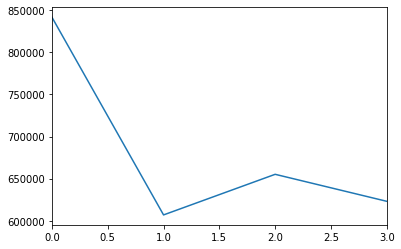

In [22]:
test = pd.read_csv('./data/evaluation_public.csv')
test['pred'] = 0
msk1 = test['regMonth']==1
msk2 = test['regMonth']==2
msk3 = test['regMonth']==3
msk4 = test['regMonth']==4
test['pred'][msk1] = pred_dict[25]
test['pred'][msk2] = pred_dict[26]
test['pred'][msk3] = pred_dict[27]
test['pred'][msk4] = pred_dict[28]

test['pred2'] = 0
test['pred2'][msk1] = pred_dict2[25]
test['pred2'][msk2] = pred_dict2[26]
test['pred2'][msk3] = pred_dict2[27]
test['pred2'][msk4] = pred_dict2[28]

alpha = 0.5
test['pred'][msk1] = test['pred'][msk1]*alpha + test['pred2'][msk1]*(1-alpha)
test['pred'][msk2] = test['pred'][msk2]*alpha + test['pred2'][msk2]*(1-alpha)
test['pred'][msk3] = test['pred'][msk3]*alpha + test['pred2'][msk3]*(1-alpha)
test['pred'][msk4] = test['pred'][msk4]*alpha + test['pred2'][msk4]*(1-alpha)

test['pred'][msk1] = test['pred'][msk1]*1.1
test['pred'][msk2] = test['pred'][msk2]*1.2
test['pred'][msk3] = test['pred'][msk3]*1*0.87
test['pred'][msk4] = test['pred'][msk4]*1*0.87

PRED = test['pred'].values
submit = pd.read_csv('./data/evaluation_public.csv')
submit['forecastVolum'] = PRED
submit['forecastVolum'][submit['forecastVolum']<0] = 0
submit[['id','forecastVolum']].round().astype(int).to_csv('model_1.csv',encoding='utf8',index=False)
submit.groupby(['regMonth'],as_index=False).sum()['forecastVolum'].plot()

In [23]:
test2 = pd.read_csv('./data/evaluation_public.csv')
test2['pred'] = 0
msk1 = test2['regMonth']==1
msk2 = test2['regMonth']==2
msk3 = test2['regMonth']==3
msk4 = test2['regMonth']==4
test2['pred'][msk1] = pred_dict3[25]*0.82
test2['pred'][msk2] = pred_dict3[26]*0.82
test2['pred'][msk3] = pred_dict3[27]*0.82
test2['pred'][msk4] = pred_dict3[28]*0.82

test2['pred2'] = 0
test2['pred2'][msk1] = pred_dict4[25]*0.8
test2['pred2'][msk2] = pred_dict4[26]*0.8
test2['pred2'][msk3] = pred_dict4[27]*0.8
test2['pred2'][msk4] = pred_dict4[28]*0.8

alpha = 0.5
test2['pred'][msk1] = test2['pred'][msk1]*alpha + test2['pred2'][msk1]*(1-alpha)
test2['pred'][msk2] = test2['pred'][msk2]*alpha + test2['pred2'][msk2]*(1-alpha)
test2['pred'][msk3] = test2['pred'][msk3]*alpha + test2['pred2'][msk3]*(1-alpha)
test2['pred'][msk4] = test2['pred'][msk4]*alpha + test2['pred2'][msk4]*(1-alpha)

#test2['pred'] *= 0.98
test2['pred'][msk3] = test2['pred'][msk3]*0.87
test2['pred'][msk4] = test2['pred'][msk4]*0.87

PRED = test2['pred'].values
submit = pd.read_csv('./data/evaluation_public.csv')
submit['forecastVolum'] = PRED
submit['forecastVolum'][submit['forecastVolum']<0] = 0
submit[['id','forecastVolum']].round().astype(int).to_csv('model_2.csv',encoding='utf8',index=False)

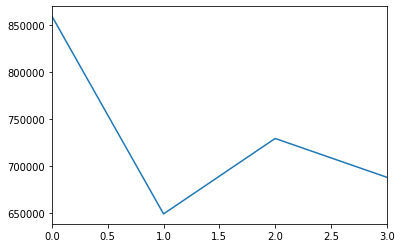

In [24]:
submit.groupby(['regMonth'],as_index=False).sum()['forecastVolum'].plot()

### 生成提交文件

In [25]:
test = pd.read_csv('./data/evaluation_public.csv')

test['pred'] = pd.read_csv('model_2.csv')['forecastVolum'].values
test['pred2'] = pd.read_csv('model_1.csv')['forecastVolum'].values

msk1 = test['regMonth']==1
msk2 = test['regMonth']==2
msk3 = test['regMonth']==3
msk4 = test['regMonth']==4

# 两个模型结果加权
test['pred'][msk1] = test['pred'][msk1]*0.5 + test['pred2'][msk1]*0.5
test['pred'][msk2] = test['pred'][msk2]*0.5 + test['pred2'][msk2]*0.5
test['pred'][msk3] = test['pred'][msk3]*0.5 + test['pred2'][msk3]*0.5
test['pred'][msk4] = test['pred'][msk4]*0.5 + test['pred2'][msk4]*0.5

PRED = test['pred'].values
submit = pd.read_csv('./data/evaluation_public.csv')
submit['forecastVolum'] = PRED
submit['forecastVolum'][submit['forecastVolum']<0] = 0
submit[['id','forecastVolum']].round().astype(int).to_csv('submit.csv',encoding='utf8',index=False)